<a href="https://colab.research.google.com/github/prishabhatia20/DSA/blob/main/Assignment_16_Convolutional_Neural_Networks_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks in PyTorch

In this notebook, we will introduce convolutional neural networks, learning how to train them and how to use them to make predictions. It includes some review illustration of convolutions and pooling.


Note: In addition to Sam and Paul, this notebook builds on code from a [notebook](https://colab.research.google.com/github/goodboychan/chans_jupyter/blob/main/_notebooks/2020-07-29-01-Convolutional-Neural-Networks-in-PyTorch.ipynb#scrollTo=EPDNHRE5PXYI) from Google by Chanseok Kang and includes material from a lecture "Introduction to Deep Learning with PyTorch" via datacamp, Stanfords CS321, and ChatGPT which sources from multiple places.

Exercises:
* manipulate the variables until you can overfit the data.
* read some parts of the code
* write a simple neural network (maybe make them sort out the dimensions in class)
* write your own model for desserts
* use transfer learning

add in some code to visualize the class output over time for a test image with no grad.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import random
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision import datasets, transforms
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the current device
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using GPU: Tesla T4


#Load the data

This code helps you choose a subset of the data. We are going to start with a small bit of data.

In [2]:
# Complete transform for both grayscale and RGB images
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize if necessary
    #transforms.Resize((224, 224)),  # Resize if necessary
    transforms.ToTensor(),
    transforms.Lambda(lambda x: transforms.Normalize(0.5, 0.5)(x) if x.size(0) == 1 else transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(x))
])

data_source = 'mnist'

match data_source:
  case 'mnist':
    # Load from MNIST
    train_set = torchvision.datasets.MNIST('mnist', train=True, transform=transform,download=True)
    test_set = torchvision.datasets.MNIST('mnist', train=False, transform=transform)
  case 'cifar10':
    # Load from CIFAR-10
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
  case 'desserts':
    from os import mkdir, system, path
    if path.exists('machine_learning_a2/train_data/images')==False:
      print("downloading data")
      !git clone https://github.com/olinml2024/machine_learning_a2
      %cd machine_learning_a2
      from data_utils import download_dessert_test_data
      download_dessert_test_data()
      import gdown
      gdown.download(id="1k_KaPCCO37HC8eqpd0D0JhKyGhqM8_KL", output="train_data.zip")
      mkdir('train_data')
      system('unzip -q test_data.zip -d train_data')
      %cd ..
    train_set = datasets.ImageFolder('machine_learning_a2/train_data/images', transform)
    test_set = datasets.ImageFolder('machine_learning_a2/test_data/images', transform)

def create_balanced_subset(dataset, selected_classes, samples_per_class, transform=None,batch_size=32):
    """
    Creates a balanced subset of the dataset with specified classes and samples per class.

    Parameters:
    - dataset: The original dataset (e.g., MNIST, CIFAR-10).
    - selected_classes: List of class indices to include in the subset.
    - samples_per_class: Number of examples to sample per class.
    - transform: Optional transformation to apply to the images.

    Returns:
    - DataLoader for the balanced subset.
    """
    # Ensure the dataset uses the expected format
    if not isinstance(dataset, Dataset):
        raise ValueError("The provided dataset must be a PyTorch Dataset.")

    # Group indices by class
    class_indices = {cls: [] for cls in selected_classes}

    for idx, (_, label) in enumerate(dataset):
        if label in selected_classes:
            class_indices[label].append(idx)

    # Sample from each class
    sampled_indices = []
    for cls in selected_classes:
        if len(class_indices[cls]) < samples_per_class:
            raise ValueError(f"Not enough samples for class {cls}. Available: {len(class_indices[cls])}, Required: {samples_per_class}")
        sampled_indices.extend(random.sample(class_indices[cls], samples_per_class))

    # Create a subset and DataLoader
    balanced_subset = Subset(dataset, sampled_indices)
    return DataLoader(balanced_subset, batch_size=batch_size, shuffle=True,drop_last=True)


train_set.classes


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.9MB/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.08MB/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [10]:
# Specify classes to include and number of samples per class
selected_classes = [2, 4, 8]  # Example: 0 = 0, 1 = 1, 2 = 2 (digits)
train_samples_per_class = 16  # Number of examples per class
test_samples_per_class = 110
batch_size = 10

# Create a balanced subset DataLoader
train_loader = create_balanced_subset(train_set, selected_classes, train_samples_per_class, batch_size=batch_size)
test_loader = create_balanced_subset(train_set, selected_classes, test_samples_per_class, batch_size=batch_size)


# Check the number of batches, note this drops the last if not a full batch, which could exclude some of your data if the number of datapoints isn't divisible by the batch_size
print(f'Number of batches in the DataLoader: {len(train_loader)}')

num_classes = len(selected_classes)
print(num_classes)


Number of batches in the DataLoader: 4
3


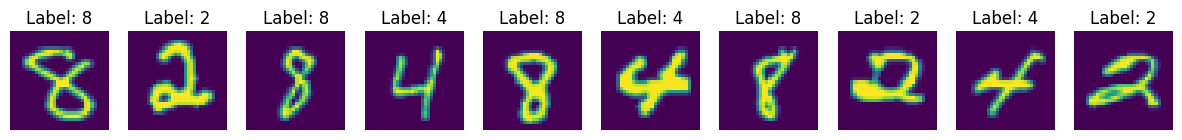

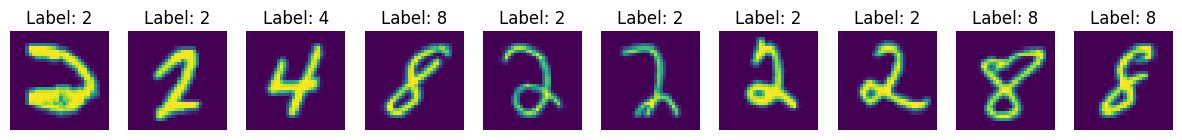

In [11]:

# Function to display a batch of images with labels
def show_sample_images(data_loader, num_images=10):
    # Get a batch of images and labels
    images, labels = next(iter(data_loader))  # Get the first batch

    # Set the number of images to display
    num_images = min(num_images, images.size(0))  # Ensure we don't exceed the batch size

    # Create a grid of images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        image = images[i].permute(1, 2, 0).detach().cpu().numpy()  # Rearrange to (H, W, C)
        image = (image - image.min()) / (image.max() - image.min())  # Normalize for visualization
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {labels[i].item()}')  # Show label
        axes[i].axis('off')  # Turn off axis

    plt.show()

# Show a sample of 10 images with labels from the train_loader
show_sample_images(train_loader, num_images=10)
show_sample_images(test_loader, num_images=10)



# Define the model


In [13]:
# Define the CNN architecture

class FC_only(nn.Module):
  def __init__(self,num_classes=2):
    super(FC_only, self).__init__()
    self.fc2 = nn.Linear(32*32, num_classes)
  def forward(self, x):
    x = x.view(x.size(0), -1)  # Flatten the tensor
    x = self.fc2(x)
    return x



## Visualize the gradients and activations

In [14]:
# Function to visualize the gradient and input activations
def visualize_gradients_and_activations(inputs, labels, model,showGradients=False,showActivations=False,showImage=True):
  if showImage:
    # Show a sample input image
    input_image = inputs[0]
    print(input_image.shape)

    plt.figure(figsize=(5, 5))
    if input_image.ndim == 3:  # Shape (C, H, W)
      input_image = input_image.permute(1, 2, 0).detach().cpu().numpy()  # Rearrange to (H, W, C)
    elif input_image.ndim == 2:  # Shape (H, W)
      input_image = input_image.detach().cpu().numpy()
    plt.imshow(input_image)  #
    plt.title(f'Input Image - Label: {labels[0].item()}\nDimensions: {input_image.shape}')
    plt.axis('off')
    plt.show()


  # Register hooks to capture gradients and activations
  gradients = []
  activations = []

  def hook_fn(module, grad_input, grad_output):
      gradients.append(grad_output)

  def forward_hook(module, input, output):
      activations.append(output)

  # Attach hooks to the model's layers
  for layer in model.children():
    #if showActivations:
    layer.register_forward_hook(forward_hook)
    #if showGradients:
    layer.register_backward_hook(hook_fn)

  # Forward pass
  outputs = model(inputs)
  loss = nn.CrossEntropyLoss()(outputs, labels)

  # Backward pass
  model.zero_grad()
  loss.backward()

  if showActivations:
    # Visualizing the activations
    fig, axes = plt.subplots(1, len(activations), figsize=(15, 5))
    for i, activation in enumerate(activations):
        activation_image = activation[0].detach().cpu().numpy()  # Get the first sample
        # Check the number of dimensions
        if activation_image.ndim == 3:  # Shape (C, H, W)
            activation_image = activation_image.transpose(1, 2, 0)  # Rearrange to (H, W, C)
            if activation_image.shape[2] > 3:  # If there are more than 3 channels, take only the first 3
                activation_image = activation_image[..., :3]
        elif activation_image.ndim == 4:  # Shape (N, C, H, W)
            activation_image = activation_image[0].detach().cpu().numpy()  # Get the first sample
            activation_image = activation_image.transpose(1, 2, 0)  # Rearrange to (H, W, C)
            if activation_image.shape[2] > 3:  # If there are more than 3 channels, take only the first 3
                activation_image = activation_image[..., :3]
        elif activation_image.ndim == 1:  # Handle 1D case if necessary
            activation_image = activation_image.reshape(-1, 1)

        # Normalize for visualization
        activation_image = (activation_image - activation_image.min()) / (activation_image.max() - activation_image.min())

        axes[i].imshow(activation_image)
        axes[i].set_title(f'Activation of Layer {i+1}\nDimensions: {activation_image.shape}')
        axes[i].axis('off')
    plt.show()

  if showGradients:
    # Visualizing the gradients
    fig, axes = plt.subplots(1, len(gradients), figsize=(15, 5))
    for i, grad in enumerate(gradients):
        grad_image = grad[0].detach().cpu().numpy()  # Get the first sample
        # Check the number of dimensions
        if grad_image.ndim == 3:  # Shape (C, H, W)
            grad_image = grad_image.transpose(1, 2, 0)  # Rearrange to (H, W, C)
            if grad_image.shape[2] > 3:  # If there are more than 3 channels, take only the first 3
                grad_image = grad_image[..., :3]
        elif grad_image.ndim == 4:  # Shape (N, C, H, W)
            grad_image = grad_image[0]  # Get the first sample without .detach() and .cpu() since it should be a tensor
            grad_image = grad_image.transpose(1, 2, 0)  # Rearrange to (H, W, C)
            if grad_image.shape[2] > 3:  # If there are more than 3 channels, take only the first 3
                grad_image = grad_image[..., :3]
        elif grad_image.ndim == 1:  # Handle 1D case if necessary
            grad_image = grad_image.reshape(-1, 1)


        # Normalize for visualization
        grad_image = (grad_image - grad_image.min()) / (grad_image.max() - grad_image.min())

        axes[i].imshow(grad_image)
        axes[i].set_title(f'Gradient of Layer {i+1}\nDimensions: {grad_image.shape}')
        axes[i].axis('off')
    plt.show()

# Train the model


In [16]:
# Initialize model, loss function, and optimizer
model = FC_only(num_classes=num_classes)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
# Lists to store training and test losses
train_losses = []
test_losses = []

num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Loop through training data
    #print("Epoch: " + str(epoch + 1))
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the same device
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    # Average training loss for the epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation phase
    model.eval()  # Set model to evaluation mode
    running_test_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  #
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

    # Average test loss for the epoch
    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    if (epoch + 1) % 1000 == 0: # Every x epochs, print the loss
      # Print losses for the current epoch
      print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')


    # Visualize every epoch
    if (epoch + 1) % 100 == 0:#
      #gray_value = 0.99  # Gray level (0.0 to 1.0)
      #gray_input = torch.full((4, 1, 32, 32), gray_value)  # Shape: (batch, channels, height, width)
      visualize_gradients_and_activations(inputs, labels, model,showGradients=True,showActivations=True,showImage=True)

print("Training complete.")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


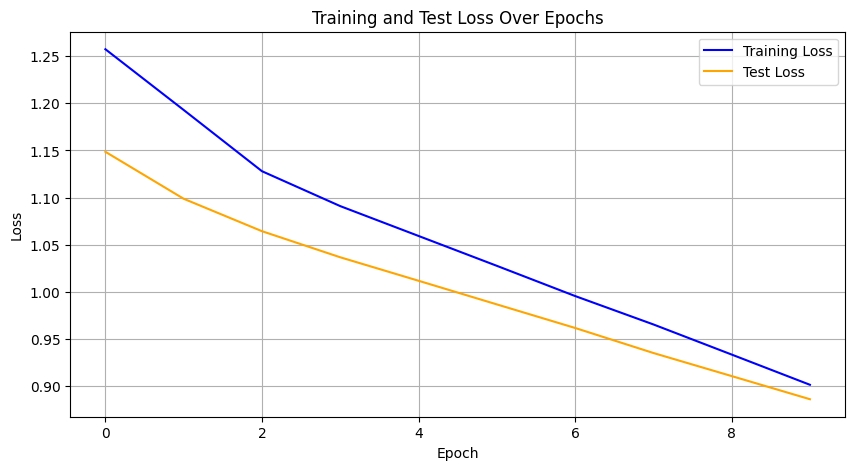

In [8]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='orange')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

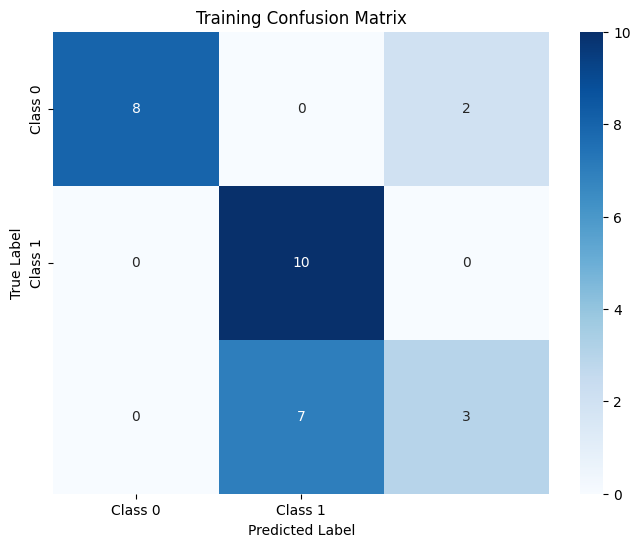

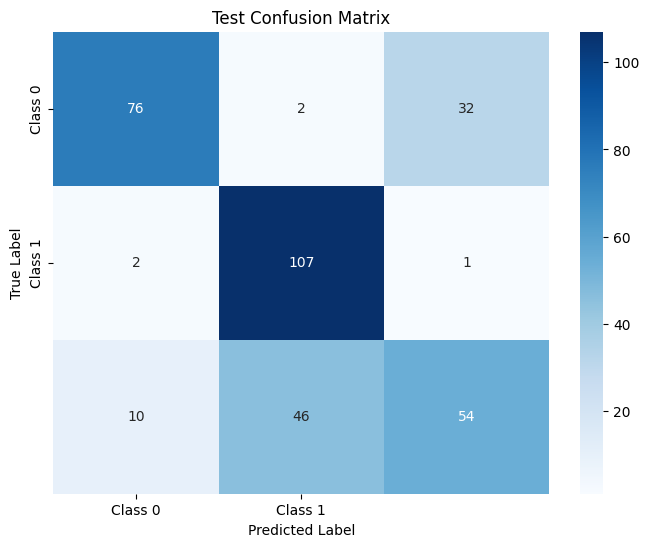

Training Accuracy: 0.7000
Test Accuracy: 0.7182
Training F1 Score: 0.6765
Test F1 Score: 0.7078


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Function to calculate confusion matrix
def calculate_confusion_matrix(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the same device
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class index
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Calculate confusion matrices for training and test data
train_labels, train_preds = calculate_confusion_matrix(model, train_loader)
test_labels, test_preds = calculate_confusion_matrix(model, test_loader)

# Compute confusion matrices
train_cm = confusion_matrix(train_labels, train_preds)
test_cm = confusion_matrix(test_labels, test_preds)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Define class names for the confusion matrix (change based on your dataset)
# You will need to fix these manually or extract them from your data
class_names = ['Class 0', 'Class 1']

# Plot confusion matrices
plot_confusion_matrix(train_cm, class_names, title='Training Confusion Matrix')
plot_confusion_matrix(test_cm, class_names, title='Test Confusion Matrix')

# Calculate accuracy
train_accuracy = accuracy_score(train_labels, train_preds)
test_accuracy = accuracy_score(test_labels, test_preds)

# Calculate F1 scores
train_f1 = f1_score(train_labels, train_preds, average='weighted')
test_f1 = f1_score(test_labels, test_preds, average='weighted')
# Print accuracy and F1 scores
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Training F1 Score: {train_f1:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')